# Is there a calculatable correlation between car traffic and train delay in Schleswig-Holstein?


## Motivation
Unfortunately the german leader in railway transport, Deutsche Bahn, is infamous for its lack in punctuality. But to what level does this lead to the german population switching from public transportation, or trains of the Deutsche Bahn, to be more precise, to travel with a car instead? This project shall give insights into this question, by trying to correlate unpunctuality of trains and the amount of street traffic in the german federal state of Schleswig-Holstein.

More precisely the following questions are tried to be answered:

1. Do people rather take the car instead of the train, dependent on the Deutsche Bahn's punctuality?

2. Did this behaviour change over time?

In [ ]:
#TODO: DOWNLOAD DEPENDENCIES!!

In [1]:
# Import generally needed modules
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

## Finding suitable datasources

To be able to find a correlation between train punctuality (or delay) and changes in street traffic, two kinds of data are needed. From a semantical point of view:
- (Open) Data that describes the amount of traffic on the streets
- (Open) Data that describes the punctuality / delay of passenger trains of the Deutsche Bahn

For the first kind of data it is possible to find good datasets, in this case provided by BASt, as shown below. 

#### Datasource 1: BASt
* Metadata URL: https://www.bast.de/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/zaehl_node.html
* A lot of datasets are used from this source, each containg the traffic from _one_ counter of _one_ year
    - Data URL for traffic counter `<counter>` in year `<year>`: https://www.bast.de/videos/\<year\>/zst\<counter\>.zip
    - The full list of traffic counter dataset URLs from BASt may be found in `bast_all_dataset_urls.md`
* Data Type: CSV (compressed)
* License: [Datenlizenz Deutschland Namensnennung 2.0](https://www.govdata.de/dl-de/by-2-0) (see [here](https://www.bast.de/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Nutzungsbedingungen.html?nn=1819490))
* Description: Each dataset from this source contains hourly traffic measurements from one traffic counter, in the range of one year. The descriptions of the original dataset values may be found [here](https://www.bast.de/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/pdf-dateien/datensatzbeschreibung-Stundendaten.pdf?__blob=publicationFile&v=4)



Finding punctuality data for passenger trains of the Deutsche Bahn, on the other hand, is a much more frustrating, currently possibly even futile task. As discussed in [this StudOn thread](https://www.studon.fau.de/studon/ilias.php?ref_id=5003028&cmdClass=ilobjforumgui&thr_pk=354332&page=0&cmd=viewThread&cmdNode=13b:t3&baseClass=ilRepositoryGUI), this report will go into a bit more details about this problem. 
\
Generally the experience, when searching for (at best open-) data may be mixed, finding a variety of datasets for some topics, while seemingly none are published for others. In this specific case, when searching for train punctuality data, a variety of websites are presented, talking about freely available punctuality data, but then presenting no precise information on where, or dead URLs.
\
The Süddeutsche Zeitung wrote an [article](https://www.sueddeutsche.de/kolumne/tabellen-und-api-zur-bahn-verspaetung-so-kommen-sie-an-alle-daten-1.1304387) in 2012 talking about their "SZ-Zugmonitor", with which they claim to use open data and crowdsourcing to contiously create a train punctuality database. While this does sound very lucrative, unfortunately all provided URLs link to 404 pages, or in other words, either the links are broken, or the data no longer exists. This is true for all provided formats in which they published the data: an [Excel file](https://docs.google.com/open?id=0B9tKUMDnFZqmOHgtWkdxRHNSVmFaQlpWT1FQWjI2UQ), a variety of Google Fusion Tables and a provided [API](http://www.opendatacity.de/zugmonitor-api). Another [article](https://www.sueddeutsche.de/reise/verspaetungs-atlas-so-verspaetet-ist-die-bahn-in-ihrer-stadt-auf-ihrer-strecke-1.1651455) additionally presents the apparent link to a [live version](http://zugmonitor.sz.de/) of the "SZ-Zugmonitor", unfortunately again, being a dead link. 
\
zugreiseblog.de also published an [article](https://www.zugreiseblog.de/open-data-deutsche-bahn-startet-datenportal/) in 2016 talking about the Deutsche Bahn themselves opening up an open data portal for various data about their train traffic. While the provided links to an apparent REST API for train traffic and a list of datasets, again are dead links, the Deutsche Bahn does indeed still host an [open data portal](https://data.deutschebahn.com/index.html), providing some datasets and APIs. For this project however [these datasets](https://data.deutschebahn.com/dataset.groups.datasets.html) unfortunately were not helpful either, since none of them contains punctuality data for passenger trains. 

While this was just an insight into the research that was done to find suitable data, it already shows how difficult it can be to find available data for certain topics.

In the end a in no way perfect, but usable dataset was found on Mobilithek: 

#### Datasource 2: Mobilithek
* Metadata URL: https://mobilithek.info/offers/-5903353853572013168
* Data URL: https://opendata.schleswig-holstein.de/dataset/84256bd9-562c-4ea0-b0c6-908cd1e9e593/resource/c1407750-f05f-4715-8688-c0ff01b49131/download/puenktlichkeit.csv
* Data Type: CSV
* License: [Creative Commons Namensnennung – 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) (as can be seen [here](https://mobilithek.info/offers/-5903353853572013168) under the tab "Nutzungsbedingungen")
* Description: Dataset contains monthly train punctuality score per train-line for the years from 2010 to 2021.

It contains monthly train punctuality data of a selection of trainlines in the federal state of Schleswig-Holstein in germany. The punctuality is modeled as a score (with the highest value being 100.0). The dataset description on [Mobilithek](https://mobilithek.info/offers/-5903353853572013168) describes a calculation that sounds like the score may be interepreted as the percentage of punctual trains in said month. This pre-processing of more detailed data is rather unfortunate for this project, since a dataset holding more datapoints with higher frequency, would likely improve the accuracy of made correlations drastically. Another negative aspects is the fact that Mobilithek's dataset description additionally mentions, that only trains having a delay of 5 minutes or more are counted as delayed arrivals. Since this hides possibly relevant information, by not including smaller delays, this again does likely have a negative effect when trying to find correlations with other data. 



## Looking into the datasets
### Traffic counter datasets
First, the traffic counter datasets structure will be shown, to get an understanding of what the original structure looked like: 

In [3]:
# One examplary dataset is chosen; the structure is equal for all of them
df = pd.read_csv('https://www.bast.de/videos/2010/zst1173.zip', sep=None, engine='python')
df.head(10)

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,Bus_R2,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2
0,2125,1173,1,A,7,100101,5,s,1,110,...,0,-,0,-,1,-,1,-,0,-
1,2125,1173,1,A,7,100101,5,s,2,328,...,1,-,0,-,1,-,1,-,1,-
2,2125,1173,1,A,7,100101,5,s,3,264,...,0,-,0,-,0,-,0,-,0,-
3,2125,1173,1,A,7,100101,5,s,4,205,...,0,-,0,-,1,-,1,-,1,-
4,2125,1173,1,A,7,100101,5,s,5,136,...,3,-,1,-,1,-,1,-,0,-
5,2125,1173,1,A,7,100101,5,s,6,109,...,0,-,1,-,0,-,0,-,0,-
6,2125,1173,1,A,7,100101,5,s,7,108,...,1,-,0,-,6,-,6,-,0,-
7,2125,1173,1,A,7,100101,5,s,8,92,...,1,-,0,-,4,-,4,-,0,-
8,2125,1173,1,A,7,100101,5,s,9,86,...,1,-,2,-,3,-,2,-,2,-
9,2125,1173,1,A,7,100101,5,s,10,127,...,1,-,0,-,1,-,1,-,1,-


One may see various infortmation about the position of the traffic counter and the measurement interval timestamp. But most importantly various, already categorized, traffic counts, with a validity value (e.g. describing if the measured count is only an estimate). The categories include, but are not limited to cars, busses, trucks, and bikes.

To get a better understanding of data availability for the chosen traffic counter datasets, the number of available counter-datasets per year is plotted regarding all used counters. 

Text(0.5, 1.0, 'Amount of used counters with data')

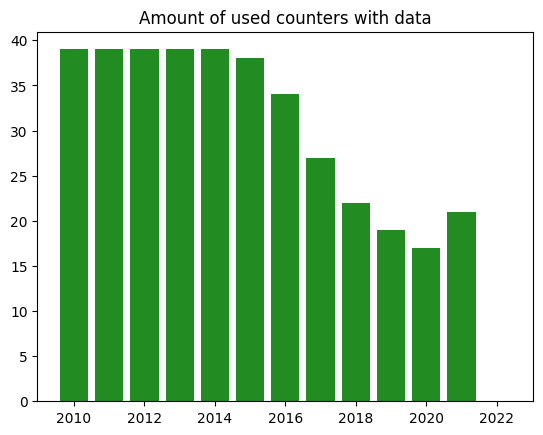

In [11]:
# Checkiung how many counter have data for a certain year
#########################################################
from trainline_traffic_counter_mapping import generate_counter_trainline_mapping

# Get all used counters from the used mapping
counter_trainline_mapping = generate_counter_trainline_mapping()
all_counter_nrs = counter_trainline_mapping.keys()

# Get db connections to the sqlite files and store in dictionary
counter_engines = {}
for traffic_counter in all_counter_nrs:
    engine = create_engine('sqlite:///../../data/traffic_counter_' + str(traffic_counter) + '.sqlite')
    counter_engines.update({traffic_counter: engine})

# Count for how many counters a table for the year was created
yearly_available_counter_data = {}
for year in range(2010, 2023):
    available_counter_count = 0
    for counter in all_counter_nrs:
        try:
            df = pd.read_sql_table(str(year), counter_engines.get(counter))
            available_counter_count += 1
        except:
            pass
        
    yearly_available_counter_data.update({year: available_counter_count})
    
plt.bar(yearly_available_counter_data.keys(), yearly_available_counter_data.values(), color='forestgreen')
plt.title('Amount of used counters with data')

As may be seen, in the beginning of the selected range of years, all selected counters do have data available, while further towards the present less counters do have data associated to them. For the year 2022 no data is present at all.


### Train punctuality dataset
As before, firstly an overview of the structure of the original dataset is given.

In [4]:
df = pd.read_csv('https://opendata.schleswig-holstein.de/dataset/84256bd9-562c-4ea0-b0c6-908cd1e9e593/resource/c1407750-f05f-4715-8688-c0ff01b49131/download/puenktlichkeit.csv', sep=None, engine='python')
df.head(10)

,linie,puenktlichkeitsniveau_an,jahr,monat
0,RB 61 Itzehoe - Hamburg (Hbf),"91,81",2010,1
1,RB 62 Heide - Itzehoe,"92,84",2010,1
2,RB 64 St.-Peter-Ording - Husum,"98,15",2010,1
3,RB 71 Wrist - Hamburg-Altona,"87,57",2010,1
4,RB 73 Eckernförde - Kiel,"89,94",2010,1
5,RB 81 Bad Oldesloe - Hamburg (Hbf),"82,78",2010,1
6,RB 84 Kiel - Lübeck,"91,73",2010,1
7,RB 85 Puttgarden - Lübeck,"92,18",2010,1
8,RB 86 Travemünde - Lübeck,"89,49",2010,1
9,RE 1 Hamburg (Hbf) - Büchen,"88,79",2010,1


The structure is rather simple, containing the trainline for which the punctuality was measured, combined with a monthly timestamp and the previously mentioned punctuality score.

To get an understanding of availability, next is measured for how many trainlines any punctuality data is available for a certain year. Additionally it is measured if a trainline has data for a year, how many datapoints are available on average.  

Text(0.5, 1.0, 'Average available datapoints per trainline')

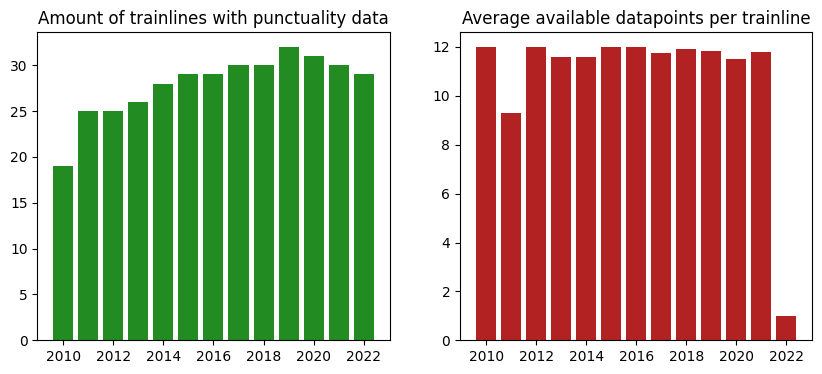

In [10]:
# Checking how many trainlines have punctuality for a certain year
from trainline_traffic_counter_mapping import generate_trainline_counter_mapping
from data_transform_utils import get_punctuality_of_year

# Get db connection for train punctuality
trainline_punc_engine = create_engine('sqlite:///../../data/train_punctuality.sqlite')
# Get all trainline names contained in dataset
trainline_counter_mapping = generate_trainline_counter_mapping()
all_trainline_names = trainline_counter_mapping.keys()

yearly_available_trainline_datasets = {}
yearly_avg_available_trainline_datapoints = {}
for year in range(2010, 2023):
    # Counter for trainlines with any data at all for that year
    available_trainline_count = 0
    # List of number of datapoints (if any) to be averaged later
    available_trainline_dp_list = []
    for trainline_name in all_trainline_names:
        df = pd.read_sql_table(trainline_name, trainline_punc_engine)
        # Determine if any data is present for year, regarding the current trainline
        available_dp = len(get_punctuality_of_year(df, year))
        if available_dp > 0:
            available_trainline_count += 1
            available_trainline_dp_list.append(available_dp)
            
            
    yearly_available_trainline_datasets.update({year: available_trainline_count})
    # Average available datapoints
    avg_dp = sum(available_trainline_dp_list) / len(available_trainline_dp_list) if len(available_trainline_dp_list) > 0 else 0
    yearly_avg_available_trainline_datapoints.update({year: avg_dp})

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(yearly_available_trainline_datasets.keys(), yearly_available_trainline_datasets.values(), color='forestgreen')
plt.title('Amount of trainlines with punctuality data')

plt.subplot(1, 2, 2)
plt.bar(yearly_avg_available_trainline_datapoints.keys(), yearly_avg_available_trainline_datapoints.values(), color='firebrick')
plt.title('Average available datapoints per trainline')

This shows that for earlier years less trainlines have punctuality data associated with them, but also that there are no years with mostly missing data. Additionally it is shown that on average a noticeable amount of measurements are missing in the year 2011, and almost all measurements in 2022. The later seems easily explained, though, since [Mobilithek](https://mobilithek.info/offers/-5903353853572013168) describes the data only containg values for january in the year 2022.

This also leads to the decision of limiting the further analysis to the years 2010 - 2021 (inclusive).

In [20]:
START_YEAR = 2010
END_YEAR   = 2021

## Dataset transformation with a pipeline
To clean the used data and transform it in various aspects, generally making later calculations easier, was done via a data pipeline.

From a software point of view, the pipeline is split into 3 parts:

### Traffic counter pipeline
A pipeline specifically designed for the traffic counter datasets. While this does make it less universal, it allows for more dataset-specific transformations. Some transformations are simple, but effective, as for example removing duplicates, or renaming and reordering columns. Others are more specific to the dataset, as for example chaning the format of the provided timeinformation to a single timestamp, merging or removing of table columns or preventive curation of rows via the timestamp and interpolation of counts. Additionally, since a resolution of hourly measurement intervals is not necessary for this project, especially considering the coarse resolution of the train punctuality data, rows were merged. To be more precise, all hourly measurements were combined to daily measurements. This still does provide enough details, but is easier to work with later on.

### Train punctuality pipeline
There also is a specialized pipeline for the train punctuality dataset. Additionally to the above mentioned simple transformations the most interesting done transformation likely is the fact, that the dataset was split into sub-datasets, one for each trainline. This is suppossed to make the reading process clearer, compared to all data being collected in one big dataset, but also allow for easier manual overview of the data.

### Combining main pipeline
Finally one part is needed that connects the two. This is conceptually done as follows. Needed datasets are abstracted into an object, which holds information such as the dataset URL, but also into which SQLite database and table the output data shall be put into. Such an object also holds the info, which specialized pipeline should be used for this dataset.
\
This leads to the workflow of simply adding such objects, defining where to find the dataset, which sub-pipeline should transform it and where the result shall be stored, and simply passing those to the main pipeline. The main pipeline than simply uses the provided data to call the correct sub-pipeline with the needed information.
This design was chosen to allow for as much automization as possible and additionally to separate data from logic more effectively.


## Correlating traffic counts with train punctuality
Now, that an introduction about the setup is given, the actual correlation process will be discussed.

### Which trainlines are mapped to which counters
One important question is, the data of which counters is considered possibly effected by some trainline. The abstract but powerful answer would be something like "the streets which might take one roughly along the trainline in question". While this does sound simple, the process of mapping counters to a trainline is more difficult than expected. One might try to implement simple algorithms which e.g. calculate the distance between a trainline and a counter. While such approaches might look interesting at first, because streets have curves and might change direction almost randomly, the task becomes much more difficult.
\
Consequently it was decided to rather take a smaller portion of trainlines, and map counters manually via comparing the streets and trainlines on maps, than implementing a hardly working algorithm, which could work through all mappings. The chosen mappings may be found in `trainline_traffic_counter_mapping.py`.

### How to quantify if regular train passengers are driving a car instead
Since we want to correlate train punctuality to, what colloquially might be described as "how many cars above the usual amount of traffic are on the road", we need a mathematical way to form such a value from the given traffic data. The biggest problem is determining what "usual" traffic is. If this would be solved, it would be easily determinable how the current traffic deviates from said usual traffic. To get an idea of what the traffic data roughly looks like, in the following the traffic data of two different counters in a few different years is plotted.

Text(0.5, 0, 'month')

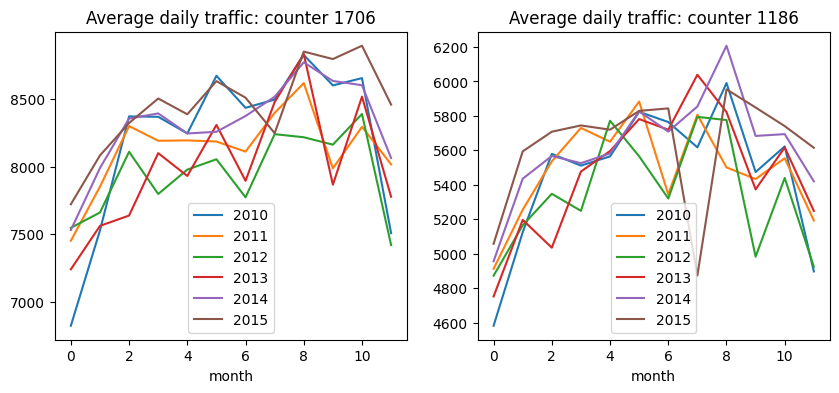

In [18]:
from data_transform_utils import get_monthly_avg_day_traffic
counters = [1706, 1186]
years = range(2010, 2016)
monthly_traffic = {}

for counter in counters:
    monthly_traffic.update({counter: {}})
    counter_db_eng = counter_engines.get(counter)
    for year in years:
        try:
            df = pd.read_sql_table(str(year), counter_db_eng)
        except ValueError:
            # Table does not exist -> traffic counter data for that year does not exist
            continue
        
        monthly_traffic.get(counter).update({year: get_monthly_avg_day_traffic(df)})
        

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
avg_monthly_traffic_per_year = monthly_traffic.get(counters[0])
for year in years:
    plt.plot(avg_monthly_traffic_per_year.get(year), label=str(year))
plt.title('Average daily traffic: counter ' + str(counters[0]))
plt.legend()
plt.xlabel('month')

plt.subplot(1, 2, 2)
avg_monthly_traffic_per_year = monthly_traffic.get(counters[1])
for year in years:
    plt.plot(avg_monthly_traffic_per_year.get(year), label=str(year))

plt.title('Average daily traffic: counter ' + str(counters[1]))
plt.legend()
plt.xlabel('month')

As one may see, even when ignoring the noticeable noise, the traffic over a year is not a flat horizontal line, but a curve, with its peak roughly in the middle of the year. 

#### Simply using the averaged measured value
To come back to why this is interesting for the correlation between the traffic and train punctuality: If a more or less flat horizontal line would roughly describe the yearly traffic, one could assume that the traffic is practically constant and factors affecting the traffic would only do so on a smaller scale. This would also mean that the baseline, for this case semantically representing "usual traffic", is constant, therefore a horizontal line as well. If that would be the case, said baseline could simply be modeled as the average of all traffic values. And this would lead to the factor "more/less than usual traffic" being simply described by the distance of the measured traffic value from said constant baseline. One could then correlate this value (being the "more/less than usual traffic" value) with train punctuality.

Unfortunately, as already meantioned, the traffic of a year is not well representable by a line, as seen in the above plots, but roughly represents a curve. This, unfortunately means, that the hoped for approximation of "usual traffic" as a constant, will likely lead to noticeably worse results when correlating, since other factors seemingly have a noticeable greater impact on traffic. 

#### Using standard deviation on weekdays
Consequently another effect that the switch from train to car would have on the car traffic data was searched for. This effect could than again tried to be measured and the results then correlated with the train punctuality data. After some thought, the following assumption was made:

It likely may be assumed that in a shorter period of time (e.g. a month) the traffic counts on a specific weekday (e.g. wednesday) will be very similar. This idea is based on the assumption that most traffic of cars is likely cause by commutes, which again are likely similar on the same weekday. Should train traffic be delayed, and passengers would decide to drive by car instead, a peak in car traffic on that weekday could be measured, while the traffic on the same weekday in the previous and next week would not show this peak.
\
To possibly minimize confusion a small example may be made: It is assumed that the car traffic on each wednesdays in march is very similar. If a train delay would occur, and passengers would switch to car on a wednesday, only that one wednesday would have higher traffic, the other wednesdays of march would still be similar in traffic count. Now one would need a mathematical way of generating a value that increases if this happens (some wednesdays having more, some less traffic) and decreases if the traffic on wednesdays in march is constantly similar.
\
As for mathematical concepts of generating a value like this, variance or standard deviation came to mind. Under the assumption that this whole hypothesis actually holds some truth, this version of generating a "did people switch from train to car" value would have another advantage: The higher resolution of the car traffic dataset, compared to the train punctuality dataset, could actually be used, since the variance or standard deviation keep more of that information than a simple average.


A summary on what techniques will be tried to represent that train passenger have not taken the train, but a car instead:
1. Simply taking the average monthly traffic as value, representing if more or less people are driving cars, which includes people who might drive by car instead of train. Has the big problem, that seemingly a lot of other factors affect the average monthly traffic count as well.
2. Using the standard deviation of the same weekdays in a month, as value representing that additional to the regular commutes more cars are currently present. This on the other hand, has the big problem that the hyptothesis is strongly based on assumptions, which might not be correct.


#### Using the whole week or only using workdays?
Next to the both just presented techniques, there is another dimension that might be of interest. The question if all seven days of the week or only non-holidays should be used. This idea again is based on the assumption that the most traffic likely is made up by commutes, which practically only happen on non-holidays. This begs the question if only using workdays for the two above mentioned techniques would yield even better results.


### Calculating and visualizing the correlations
With the two different traffic quantification techniques and the two options of using all days, or just workdays, four different variants are calculated and a correlation factor regarding the train punctuality / delay calculate for each variant.

First up, for every traffic counter, per year the four traffic quantification values (average daily traffic per month, average work-daily traffic per month, average standard variation between weekdays, average standard varianten between work-weekdays).

In [22]:
# Go through every year and and every counter and calculate 
# different quantifications for amount of car traffic
from data_transform_utils import get_avg_weekday_traffic_deviations

monthly_avg_weekday_variances = {}
monthly_avg_workday_variances = {}
monthly_avg_daily_traffic     = {}
monthly_avg_workday_traffic   = {}

# for year in range(2012, 2022):
for year in range(START_YEAR, END_YEAR+1):
    # Create dict key for the year
    monthly_avg_weekday_variances.update({year: {}})
    monthly_avg_workday_variances.update({year: {}})
    monthly_avg_daily_traffic.update({year: {}})
    monthly_avg_workday_traffic.update({year: {}})
    for counter, counter_engine in counter_engines.items():
        try:
            df = pd.read_sql_table(str(year), counter_engine)
        except ValueError:
            # Traffic measurements is not available
            continue
        
        # Retrieve different quantifications of "is there more / less traffic than usual"
        avg_weekday_var     = get_avg_weekday_traffic_deviations(df)
        avg_workday_var     = get_avg_weekday_traffic_deviations(df, only_workdays=True)
        avg_daily_traffic   = get_monthly_avg_day_traffic(df)
        avg_workday_traffic = get_monthly_avg_day_traffic(df, only_workdays=True)
        
        # Add the quantifications values for the year and counter respectively
        monthly_avg_weekday_variances.get(year).update({counter: avg_weekday_var})
        monthly_avg_workday_variances.get(year).update({counter: avg_workday_var})
        monthly_avg_daily_traffic.get(year).update({counter: avg_daily_traffic})
        monthly_avg_workday_traffic.get(year).update({counter: avg_workday_traffic})

Next up the lateness-factor (=100.0 - punctuality-factor) needs to be calculated. Since multiple trainlines might take effect on the same counter, though, this cannot be done separate but needs to be done on a per-counter basis.

The following example might clarify why this is the case: Assuming trainline A and trainline B have effect on counter C (meaning counter C measures a street which might be an alternative route to get from the start trainstation to the end trainstation). If now both A and B would have a significant delay at the same time, the addition of cars that counter C measures would be a summation of the people who usually drive trainline A _and_ B.
\
If all trainlines and counters would be looked at independetly from each other, the following would be determined: When looking at the relation between trainline A and counter C the correlation would be _doubled_, since the effect of trainline B is present, but the cause is ignored.
\
The same would happen for the relation between trainline B and counter C.

Consequently this would falsefy the result. What needs to be done instead is the following: Per counter, all trainline delay values that might have effect on the traffic, that this counter measures, need to be averaged.

This can be seen in the following.

In [24]:
# Calculate monthly average lateness from the relevant trainlines for each counter
counter_avg_train_lateness = {}

for year in range(START_YEAR, END_YEAR+1):
    counter_avg_train_lateness.update({year: {}})
    for counter in counter_engines.keys():
        # For every counter, get all relevant trainlines
        relevant_trainlines = counter_trainline_mapping.get(counter)
        # Get monthly punctuality for current year for all relevant trains
        monthly_lateness_values = [[] for i in range(12)]
        for trainline_name in relevant_trainlines:
            trainline_df = pd.read_sql_table(trainline_name, trainline_punc_engine)
            monthly_punctuality_dict = get_punctuality_of_year(trainline_df, year)
            
            for i in range(12):
                punctuality = monthly_punctuality_dict.get(i+1)                
                if punctuality is not None:
                    lateness = 100.0 - punctuality
                    monthly_lateness_values[i].append(lateness)
        
        # Calculate average lateness value of relevant trainlines for each month
        monthly_avg_lateness = [None] * 12
        for i in range(12):
            lateness_values = monthly_lateness_values[i]
            avg_lateness = 0
            if len(lateness_values) > 0:
                avg_lateness = sum(lateness_values) / len(lateness_values)
                monthly_avg_lateness[i] = avg_lateness
        
        # Add avg lateness values of counter to overall dict
        counter_avg_train_lateness.get(year).update({counter: monthly_avg_lateness})

Now that we have calculated the values for the vectors, between which a correlation might be detected, the correlation can be calculated. For simplicity the Pearson Correlation was chosen for this. The calculations for the correlations of the four different quantification techniques may be seen below.

In [27]:
# Build all correlations between the different quantizations and the lateness values
#   on a yearly and per counter basis
from scipy.stats import pearsonr

def get_cleaned_vectors(monthly_traffic_quantization: list, monthly_trainline_lateness: list):
    cleaned_monthly_traffic_quant = []
    cleaned_monthly_avg_lateness = []
    for i in range(12):
        EPSILON = 0.00001
        if (abs(monthly_traffic_quantization[i]) < EPSILON) or (monthly_trainline_lateness[i] is None):
            continue
        cleaned_monthly_traffic_quant.append(monthly_traffic_quantization[i])
        cleaned_monthly_avg_lateness.append(monthly_trainline_lateness[i])
    assert(len(cleaned_monthly_traffic_quant) == len(cleaned_monthly_avg_lateness))
    return cleaned_monthly_traffic_quant, cleaned_monthly_avg_lateness

def get_pearson_correlation(monthly_traffic_quantization: list, monthly_trainline_lateness: list):
    cleaned_monthly_traffic_quant, cleaned_monthly_avg_lateness = get_cleaned_vectors(monthly_traffic_quantization, monthly_trainline_lateness)
    if len(cleaned_monthly_traffic_quant) < 2:
        return None, None
    pearson_corr, p_value = pearsonr(cleaned_monthly_traffic_quant, cleaned_monthly_avg_lateness)
    return pearson_corr, p_value


avg_weekday_var_correlations = {}
avg_workday_var_correlations = {}
avg_daily_traffic_correlations = {}
avg_workday_traffic_correlations = {}

for year, avg_counter_latenesses in counter_avg_train_lateness.items():
    avg_weekday_var_correlations.update({year: {}})
    avg_workday_var_correlations.update({year: {}})
    avg_daily_traffic_correlations.update({year: {}})
    avg_workday_traffic_correlations.update({year: {}})
    
    for counter, avg_monthly_lateness in avg_counter_latenesses.items():
        #############################################################
        # Avg weekday variance
        monthly_avg_weekday_var = monthly_avg_weekday_variances.get(year).get(counter)
        if monthly_avg_weekday_var is not None:
            # Build correlation
            pearson_corr, p_value = get_pearson_correlation(monthly_avg_weekday_var, avg_monthly_lateness)
            if pearson_corr is not None:
                avg_weekday_var_correlations.get(year).update({counter: (pearson_corr, p_value)})
        
        #############################################################
        # Avg weekday variance
        monthly_avg_workday_var = monthly_avg_workday_variances.get(year).get(counter)
        if monthly_avg_workday_var is not None:
            # Build correlation
            pearson_corr, p_value = get_pearson_correlation(monthly_avg_workday_var, avg_monthly_lateness)
            if pearson_corr is not None:
                avg_workday_var_correlations.get(year).update({counter: (pearson_corr, p_value)})
        
        #############################################################
        # Avg daily traffic
        monthly_avg_daily = monthly_avg_daily_traffic.get(year).get(counter)
        if monthly_avg_daily is not None:
            # Build correlation
            pearson_corr, p_value = get_pearson_correlation(monthly_avg_daily, avg_monthly_lateness)
            if pearson_corr is not None:
                avg_daily_traffic_correlations.get(year).update({counter: (pearson_corr, p_value)})
            
        #############################################################
        # Avg workday traffic
        monthly_avg_workday = monthly_avg_workday_traffic.get(year).get(counter)
        if monthly_avg_workday is not None:
            # Build correlation
            pearson_corr, p_value = get_pearson_correlation(monthly_avg_workday, avg_monthly_lateness)
            if pearson_corr is not None:
                avg_workday_traffic_correlations.get(year).update({counter: (pearson_corr, p_value)})

<Axes: xlabel='year', ylabel='pearson_correlation'>

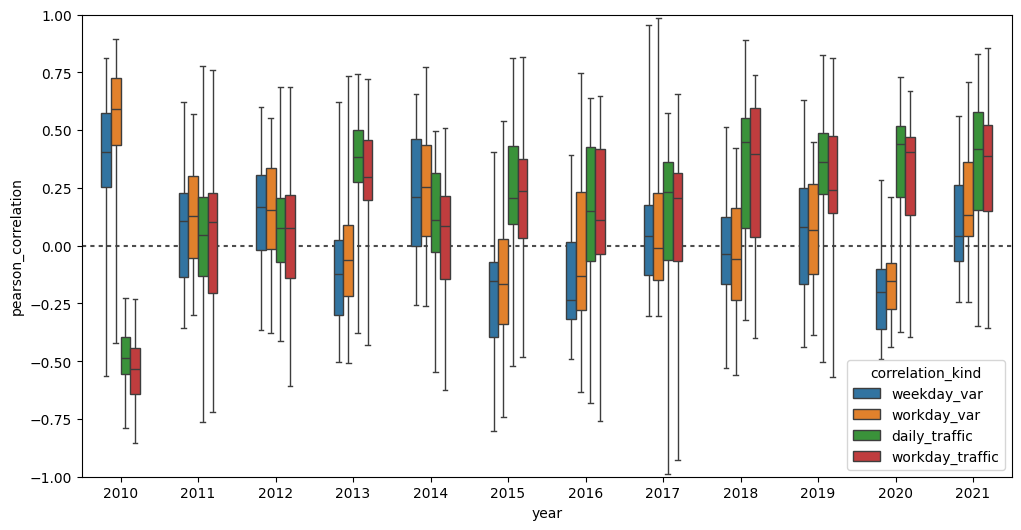

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

boxpl_data = []
for correlation_kind, yearly_correlation_dict in [('weekday_var', avg_weekday_var_correlations), ('workday_var', avg_workday_var_correlations), 
                                                  ('daily_traffic', avg_daily_traffic_correlations), ('workday_traffic', avg_workday_traffic_correlations)]:
    # Convert dictionaries to format for boxplot
    for year, correlation_dict in yearly_correlation_dict.items():
        for counter, correlation in correlation_dict.items():
            row = {'correlation_kind': correlation_kind, 'year': year, 'counter': counter, 'pearson_correlation': correlation[0], 'p_value': correlation[1]}
            boxpl_data.append(row)

boxpl_df = pd.DataFrame(data=boxpl_data)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim([-1, 1])
ax.axhline(0, color=".3", dashes=(2,2))
sns.boxplot(data=boxpl_df, x='year', y='pearson_correlation', hue='correlation_kind', width=0.5, whis=[0, 100])

The above seen boxplot shows the Pearson correlation of the four previously mentioned quantification techniques categorized in the different years. "weekday_var" means the standard deviation on all weekdays, while "workday_var" only includes the workdays. "daily_traffic" described the average daily traffic values, while "workday_traffic" only includes the workdays.

A Pearson correlation of +1.0 is equivalent to a perfect linear relationship, a correlation of 0.0 can be interpreted as no relationship at all and a correlation of -1.0 is equivalent to a perfect negative / inverted linear relationship.

## Interpretation and Conclusion

If we simply try to determine, which quantification technique did result in the highest Pearson correlation, the quantifactions based on the average traffic data yielded better results, meaning a higher correlation is present. 

The standard deviation quantification techniques on the other hand generally sit closer to a correlation of 0 (meaning no correlation), and additionally seem to show a lot more variance, meaning for some years a positive linear correlation was determined, for others a negative one. Semantically, this would mean that in some years, people indeed did take the car if trains in those regions had a higher delay, while in other years the exact opposite would have happened. While this is not impossible, it seems far more likely that the previously made assumptions that lead to the standard deviation based tries were either incorrect or that other factors effect the deviation of weekday values on a similar or even higher scale.

The results for the average daily traffic seem to more consistently lead to a positive Pearson correlation, but even here the correlation factor most often is close to 0, consequently likely not showing a meaningful result. Additionally the individually calculate correlation factors do have a significant spread (noted by the vertical lines above and below the boxes, each line reaching the highest / lowest sample). This again is a sign of a lot of noise / randomness in the calculated results, giving positive results less semantic weight.

To finally answer the questions of this project:

### Do people rather take the car instead of the train, dependent on the Deutsche Bahn's punctuality?
While one might interpret the somewhat stable positive correlation factor, of the average-traffic-based results, somewhat leaning towards yes, it seems more likely that the found correlation stems from another factor, which was not included in the scope of this project. One example could be the fact that, as previously shown, more traffic is generally found during the summer. If the Deutsche Bahn would also have higher delays in the summer for completely unrelated reasons, this still would result in a viewable correlation, even though the cause is completely different.

In summary: The found results do not show enough correlation to confidently answer this question with yes. While also not greatly proven, the results tend more towards no. It should be noted though, that this result is directly related to the used datasets and calculations. The greatly limited coarse resolution of the train punctuality data is a likely candidate, for worsening the results. Other correlation algorithms might have yielded better results, or different hypothesis would have lead to better quantification. All that can be said with some certainty, is that the presented results do not seem to hint at a great correlation between train punctuality and street traffic.  

